# Load the dataset
The dataset is a collection of shopping queries, products, and sources. It contains examples of queries with labeled products, which can be used for various analyses and machine learning tasks.
The original dataset is available at [https://github.com/amazon-science/esci-data](https://github.com/amazon-science/esci-data).

In [1]:
import logging
import sys
from pathlib import Path
from pprint import pprint
from typing import Dict, Tuple

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
from plotly.subplots import make_subplots

FONT_SIZE_VALUE = 9

SAFE_PGF = False
LOAD_LOCAL = True

# set stout logging to info

data_set_dir = Path("shopping_queries_dataset")

logging.basicConfig(stream=sys.stdout, level=logging.WARNING)

In [2]:
# Load the dataset
df_examples = pd.read_parquet(
    data_set_dir / "shopping_queries_dataset_examples.parquet"
)
df_products = pd.read_parquet(
    data_set_dir / "shopping_queries_dataset_products.parquet"
)
df_sources = pd.read_csv(data_set_dir / "shopping_queries_dataset_sources.csv")

## Display the first few rows of each dataframe

In [3]:
display(df_examples.head(3))

,example_id,query,query_id,product_id,product_locale,esci_label,small_version,large_version,split
0,0,revent 80 cfm,0,B000MOO21W,us,I,0,1,train
1,1,revent 80 cfm,0,B07X3Y6B1V,us,E,0,1,train
2,2,revent 80 cfm,0,B07WDM7MQQ,us,E,0,1,train


In [4]:
display(df_products.head(3))

,product_id,product_title,product_description,product_bullet_point,product_brand,product_color,product_locale
0,B079VKKJN7,"11 Degrees de los Hombres Playera con Logo, Ne...",Esta playera con el logo de la marca Carrier d...,11 Degrees Negro Playera con logo\nA estrenar ...,11 Degrees,Negro,es
1,B079Y9VRKS,Camiseta Eleven Degrees Core TS White (M),None,None,11 Degrees,Blanco,es
2,B07DP4LM9H,11 Degrees de los Hombres Core Pull Over Hoodi...,La sudadera con capucha Core Pull Over de 11 G...,11 Degrees Azul Core Pull Over Hoodie\nA estre...,11 Degrees,Azul,es


In [5]:
display(df_sources.head(3))

,query_id,source
0,0,other
1,1,negations
2,2,negations


## Describe dataset

In [6]:
fact_dict_examples = {
    "description_products_per_query": df_examples.groupby("query_id")["product_id"]
    .nunique()
    .describe(),
    "unique_esci_label": df_examples["esci_label"].unique(),
    "unique_query_ids": df_examples["query_id"].unique().shape[0],
    "product_columns": df_products.columns.tolist(),
}
pprint(fact_dict_examples)

{'description_products_per_query': count    130652.000000
mean         20.063130
std           9.339626
min           8.000000
25%          16.000000
50%          16.000000
75%          16.000000
max         198.000000
Name: product_id, dtype: float64,
 'product_columns': ['product_id',
                     'product_title',
                     'product_description',
                     'product_bullet_point',
                     'product_brand',
                     'product_color',
                     'product_locale'],
 'unique_esci_label': array(['I', 'E', 'S', 'C'], dtype=object),
 'unique_query_ids': 130652}


In [7]:
# Aggregieren: Anzahl unterschiedlicher Produkte pro Query und Locale
product_counts_per_query = (
    df_examples.groupby(["query_id", "product_locale"])["product_id"]
    .nunique()
    .reset_index(name="product_count")
)
# Einzigartige Locales bestimmen
locales = sorted(product_counts_per_query["product_locale"].unique())

# Subplots initialisieren
fig = make_subplots(rows=len(locales), cols=1, subplot_titles=locales)

# Für jede Locale einen Subplot erstellen
for i, locale in enumerate(locales, start=1):
    locale_data = product_counts_per_query[
        product_counts_per_query["product_locale"] == locale
    ]

    fig.add_trace(
        go.Histogram(
            x=locale_data["product_count"],
            name=locale,
            nbinsx=50,
            marker=dict(line=dict(width=1, color="black")),
        ),
        row=i,
        col=1,
    )

# Layout anpassen
fig.update_layout(
    title_text="Verteilung der Anzahl Produkte pro Query (pro Locale)",
    showlegend=False,
    height=400 * len(locales),
    width=1200,
    bargap=0.2,
)

# Achsenbeschriftungen setzen
for i in range(1, len(locales) + 1):
    fig.update_xaxes(title_text="Produktanzahl", row=i, col=1)
    fig.update_yaxes(title_text="Häufigkeit", row=i, col=1)

fig.show()

## Reduce dataset to a smaller subset
* see description of `DataReducer` in `prepare_data.py`

In [8]:
from prepare_data import DataReducer

save_dir = data_set_dir / "reduced"
reducer = DataReducer(
    df_examples=df_examples,
    df_products=df_products,
)
if LOAD_LOCAL:
    df_examples_reduced = pd.read_parquet(
        save_dir / "shopping_queries_dataset_examples_reduced.parquet"
    )
    df_products_reduced = pd.read_parquet(
        save_dir / "shopping_queries_dataset_products_reduced.parquet"
    )
else:
    (df_examples_reduced, ex_path), (df_products_reduced, pr_path), summary = (
        reducer.reduce(save_dir=save_dir)
    )
df_examples_reduced_long = reducer._to_long_if_wide(df_examples_reduced)

In [9]:
desc = reducer.describe_dataset(
    df_examples_reduced, df_products_reduced, top_k=5, locale="de_DE", pretty=True
)

# Console-Ausgabe (schön formatiert):
print("\n--- Erweiterte Beschreibung des reduzierten Datensatzes ---\n")
for line in desc["pretty_lines"]:
    print(line)


--- Erweiterte Beschreibung des reduzierten Datensatzes ---

Anzahl Queries (reduziert): 39 161 von 130 652 = 29.97%
Anzahl Produkte (reduziert, total): 591 347 von 1 802 772 = 32.80%
Produkte im reduzierten Beispiel-Datensatz (unique): 439 212 → Produktabdeckung: 24.36%
Query-Produkt-Paare (reduziert): 587 349

Verteilung ESCI-Labels (in %):
  C: 2.34%
  E: 72.07%
  I: 7.45%
  S: 18.14%

E: exact – exaktes Match
S: substitute – geeigneter Ersatz
C: complement – sinnvolle Ergänzung
I: irrelevant – kein Bezug zur Suchanfrage

Statistische Kennzahlen: Produkte pro Query
  count: 39161.0
  mean: 15.0
  std: 6.54
  min: 10.0
  25%: 11.0
  50%: 13.0
  75%: 15.0
  max: 74.0

Top 5 Produkte (vorkommende Queries):
  TruSkin Vitamin C Serum for Face, Anti Aging Serum with Hyal…: 61
  1ml Oral Syringe - 100 Pack – Luer Slip Tip, No Needle, Ster…: 56
  Ashwagandha 1300mg Made with Organic Ashwagandha Root Powder…: 50
  CYGNUS SUPPLIES 4 Pack - 10ml Syringes Without Needle for Me…: 46
  DEPEPE 12

## Display the distribution of the number of products per query


In [10]:
product_counts_per_query = (
    df_examples_reduced_long.groupby(["query_id"])["product_id"]
    .nunique()
    .reset_index(name="product_count")
)

fig = make_subplots(rows=2, cols=1)
# make a histogram of the product_count and a horizontal boxplot of the product_count
fig.add_trace(
    go.Histogram(
        x=product_counts_per_query["product_count"],
        name="Product Count",
        nbinsx=50,
        marker=dict(line=dict(width=1, color="black")),
    ),
    row=1,
    col=1,
)
fig.add_trace(
    go.Box(
        x=product_counts_per_query["product_count"],
        name="Product Count",
        boxpoints="all",
        jitter=0.3,
        pointpos=-1.8,
    ),
    row=2,
    col=1,
)
fig.update_layout(
    title_text="Verteilung der gelabelden Produkte pro Query (US)",
    showlegend=False,
    height=800,
    width=1200,
    bargap=0.2,
)
fig.update_xaxes(title_text="Produktanzahl", row=1, col=1)
fig.update_yaxes(title_text="Häufigkeit", row=1, col=1)
fig.update_yaxes(title_text="Produktanzahl", row=2, col=1)
# x achse in log scale
fig.update_xaxes(type="log", row=1, col=1)
fig.show()

In [11]:
def configure_matplotlib_pgf(safe_pgf: bool) -> Path:
    """
    Configure Matplotlib for PGF export if `safe_pgf` is True.

    Parameters
    ----------
    safe_pgf : bool
        If True, activates the PGF backend and LaTeX rendering for Matplotlib.
    """
    output_subdir = "src/code_output/3"
    output_path = Path().absolute().parent / output_subdir
    if safe_pgf:
        matplotlib.use("pgf")
        matplotlib.rcParams.update(
            {
                "pgf.texsystem": "pdflatex",
                "font.family": "serif",
                "text.usetex": True,
                "pgf.rcfonts": False,
            }
        )
    return output_path


def plot_esci_label_distribution(
    df_long: pd.DataFrame,
    safe_pgf: bool,
    output_path: Path | None,
    filename: str = "label_distribution.pgf",
) -> Dict[str, Tuple[float, float, float]]:
    """
    Plot the overall ESCI label distribution (absolute + relative counts).

    Parameters
    ----------
    df_long : pd.DataFrame
        Long-format DataFrame with at least column `esci_label`.
    safe_pgf : bool
        If True, save as PGF to `output_path / filename`, otherwise show plot.
    output_path : Path | None
        Base path for PGF export (must not be None if `safe_pgf` is True).
    filename : str
        Output filename for PGF export.

    Returns
    -------
    Dict[str, Tuple[float, float, float]]
        Mapping from ESCI label to a tuple of RGB color components, used for later plots.
    """
    label_counts = df_long["esci_label"].value_counts().reset_index()
    label_counts.columns = ["esci_label", "count"]
    label_counts["percentage"] = (
        label_counts["count"] / label_counts["count"].sum() * 100
    ).round(2)

    colors = sns.color_palette("Set2", n_colors=4)
    plt.figure(figsize=(7, 5))
    ax = sns.barplot(
        x="esci_label",
        y="count",
        data=label_counts,
        hue="esci_label",
        palette=colors,
        legend=False,
    )

    for patch, perc, cnt in zip(
        ax.patches, label_counts["percentage"], label_counts["count"]
    ):
        ax.annotate(
            f"{cnt}\n({perc}%)",
            (patch.get_x() + patch.get_width() / 2.0, patch.get_height()),
            ha="center",
            va="bottom",
            fontsize=FONT_SIZE_VALUE,
        )

    plt.xlabel("ESCI Label")
    plt.ylabel("Anzahl der Produkte")
    plt.title("Verteilung der ESCI-Relevanzlabels")
    plt.tight_layout()

    if safe_pgf:
        assert (
            output_path is not None
        ), "output_path must not be None when safe_pgf is True."
        plt.savefig(output_path / filename)
    else:
        plt.show()

    plt.close()

    # konsistente Farbzuteilung für E, S, C, I
    label_order = ["E", "S", "C", "I"]
    label_colors: Dict[str, Tuple[float, float, float]] = dict(zip(label_order, colors))
    return label_colors


def plot_products_per_query(
    df_long: pd.DataFrame,
    safe_pgf: bool,
    output_path: Path | None,
    filename: str = "products_per_query.pgf",
    bin_size: int = 1,
    xtick_step: int = 10,
) -> None:
    """
    Plot the distribution of the number of labeled products per query (log-scaled y-axis).

    Parameters
    ----------
    df_long : pd.DataFrame
        Long-format DataFrame with columns `query_id` and `product_id`.
    safe_pgf : bool
        If True, save as PGF to `output_path / filename`, otherwise show plot.
    output_path : Path | None
        Base path for PGF export (must not be None if `safe_pgf` is True).
    filename : str
        Output filename for PGF export.
    bin_size : int
        Bin width for the histogram.
    xtick_step : int
        Step size for x-axis ticks.
    """
    products_per_query = df_long.groupby("query_id")["product_id"].count()
    stats = products_per_query.describe(percentiles=[0.25, 0.5, 0.75])

    stats_table = pd.DataFrame(
        {
            "Statistik": ["Min", "25%-Quantil", "Median", "75%-Quantil", "Max"],
            "Wert": [
                int(stats["min"]),
                int(stats["25%"]),
                int(stats["50%"]),
                int(stats["75%"]),
                int(stats["max"]),
            ],
        }
    )

    plt.figure(figsize=(8, 6))

    max_val = int(products_per_query.max())
    bins = np.arange(0, (max_val // bin_size + 1) * bin_size + 1, bin_size)

    sns.histplot(products_per_query, bins=bins, edgecolor="black")

    plt.yscale("log")

    xticks = np.arange(0, (max_val // xtick_step + 1) * xtick_step, xtick_step)
    plt.xticks(xticks)

    plt.xlabel("Anzahl der gelabelten Produkte pro Query")
    plt.ylabel("Anzahl Queries (log-Skala)")

    table = plt.table(
        cellText=stats_table.values,
        colLabels=stats_table.columns,
        cellLoc="center",
        colLoc="center",
        bbox=[0.65, 0.6, 0.3, 0.3],
        edges="horizontal",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(FONT_SIZE_VALUE)

    plt.tight_layout()

    if safe_pgf:
        assert (
            output_path is not None
        ), "output_path must not be None when safe_pgf is True."
        plt.savefig(output_path / filename)
    else:
        plt.show()

    plt.close()


def plot_products_per_query_by_label(
    df_long: pd.DataFrame,
    label_colors: Dict[str, Tuple[float, float, float]],
    safe_pgf: bool,
    output_path: Path | None,
    filename: str = "products_per_query_by_label.pgf",
) -> None:
    """
    Plot four subplots (E, S, C, I) showing the distribution of products per query
    for each ESCI label with log-scaled y-axis and embedded statistics.

    Parameters
    ----------
    df_long : pd.DataFrame
        Long-format DataFrame with columns `query_id`, `product_id` and `esci_label`.
    label_colors : Dict[str, Tuple[float, float, float]]
        Color mapping per ESCI label (e.g. from `plot_esci_label_distribution`).
    safe_pgf : bool
        If True, save as PGF to `output_path / filename`, otherwise show plot.
    output_path : Path | None
        Base path for PGF export (must not be None if `safe_pgf` is True).
    filename : str
        Output filename for PGF export.
    """
    labels = ["E", "S", "C", "I"]
    label_names = ["Exact", "Substitute", "Complement", "Irrelevant"]

    # Daten pro Label vorbereiten
    label_data: Dict[str, pd.Series] = {}
    for label in labels:
        subset = df_long[df_long["esci_label"] == label]
        label_data[label] = subset.groupby("query_id")["product_id"].count()

    # gemeinsame x-Limits und Bins bestimmen
    all_values = np.concatenate([s.values for s in label_data.values() if len(s) > 0])
    if len(all_values) == 0:
        # Keine Daten – vorzeitig abbrechen
        return

    max_val = int(all_values.max())
    bin_size = 1
    bins = np.arange(0, max_val + bin_size + 1, bin_size)

    y_max = (
        np.ceil(
            np.max([len(series) for series in label_data.values() if len(series) > 0])
            / 10
        )
        * 10
    )
    x_max = np.ceil(max_val / 5) * 5

    # Statistik pro Label berechnen
    label_stats: Dict[str, Dict[str, float]] = {}
    for label in labels:
        series = label_data[label]
        stats = series.describe(percentiles=[0.25, 0.5, 0.75])
        label_stats[label] = {
            "Min": int(stats["min"]),
            "25%": int(stats["25%"]),
            "Median": int(stats["50%"]),
            "75%": int(stats["75%"]),
            "Max": int(stats["max"]),
            "Mean": round(float(stats["mean"]), 2),
        }

    fig, axes = plt.subplots(2, 2, figsize=(10, 6))

    for i, (label, name) in enumerate(zip(labels, label_names)):
        row, col = divmod(i, 2)
        ax = axes[row, col]
        series = label_data[label]

        ax.hist(
            series,
            bins=bins,
            color=label_colors.get(label, (0.5, 0.5, 0.5)),
            edgecolor="black",
            alpha=0.7,
        )

        ax.set_yscale("log")
        ax.set_ylim(1, y_max)

        ax.set_title(f"Label: {name} ({label})")
        ax.set_xlabel("Anzahl der gelabelten Produkte pro Query")
        ax.set_ylabel("Anzahl Queries (log-Skala)")

        ax.set_xlim(0, x_max)

        stats_text = (
            f"Statistik:\n"
            f"Min: {label_stats[label]['Min']}\n"
            f"25%: {label_stats[label]['25%']}\n"
            f"Median: {label_stats[label]['Median']}\n"
            f"75%: {label_stats[label]['75%']}\n"
            f"Max: {label_stats[label]['Max']}\n"
            f"Mean: {label_stats[label]['Mean']}"
        )

        ax.text(
            0.95,
            0.95,
            stats_text,
            transform=ax.transAxes,
            va="top",
            ha="right",
            bbox={"boxstyle": "round", "facecolor": "white", "alpha": 0.8},
            fontsize=FONT_SIZE_VALUE,
        )

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    if safe_pgf:
        assert (
            output_path is not None
        ), "output_path must not be None when safe_pgf is True."
        plt.savefig(output_path / filename)
    else:
        plt.show()

    plt.close("all")

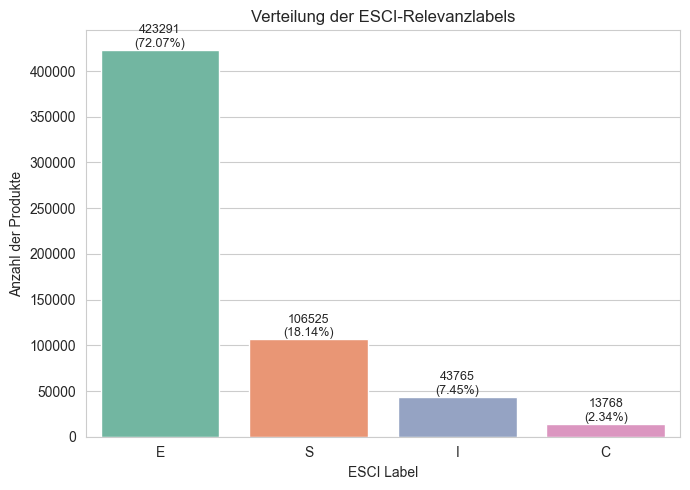

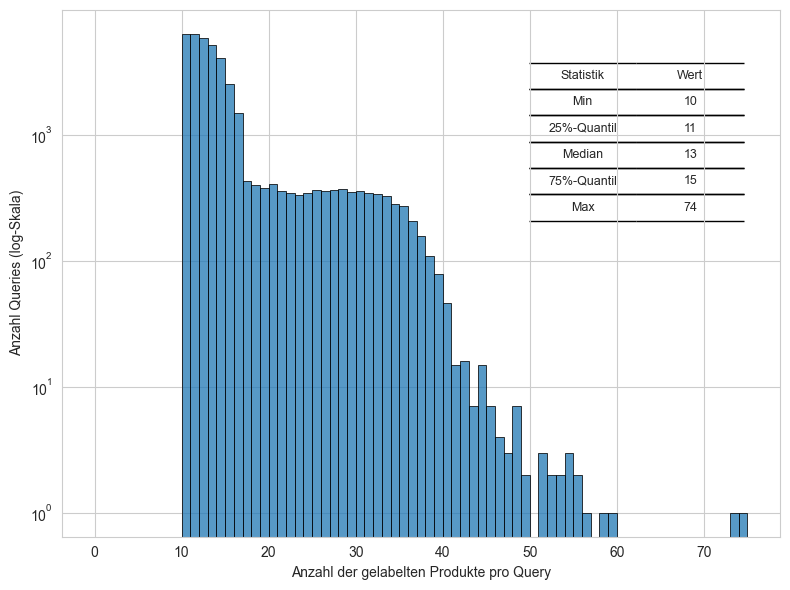

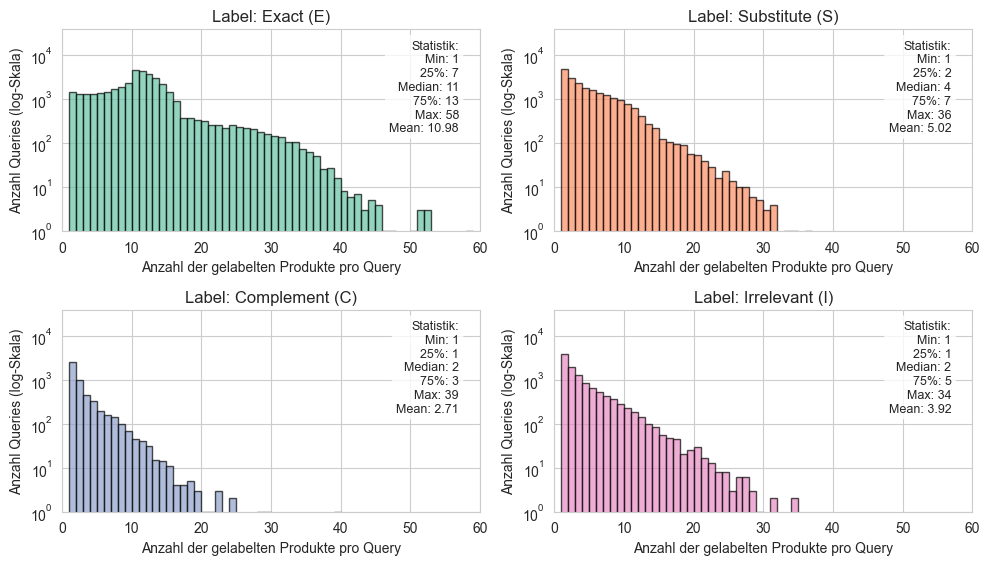

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [16]:
# ===== Beispiel-Hauptaufruf =====
for safe_pgf in [False, True] if SAFE_PGF else [False]:
    path_to_save = configure_matplotlib_pgf(safe_pgf=safe_pgf)

    label_colors = plot_esci_label_distribution(
        df_long=df_examples_reduced_long,
        safe_pgf=safe_pgf,
        output_path=path_to_save,
    )

    plot_products_per_query(
        df_long=df_examples_reduced_long,
        safe_pgf=safe_pgf,
        output_path=path_to_save,
    )

    plot_products_per_query_by_label(
        df_long=df_examples_reduced_long,
        label_colors=label_colors,
        safe_pgf=safe_pgf,
        output_path=path_to_save,
    )

## Tolenanzahl der Produktattribute

In [13]:
from embedder import Qwen3Embedding06BEmbedder
import pandas as pd

embedder = Qwen3Embedding06BEmbedder()
tok_df_examples, tok_df_products = embedder.get_count_tokens_examples_products()
df = pd.concat([tok_df_examples.describe(), tok_df_products.describe()], axis=1)

cpu wird verwendet


In [14]:
# Kopie und saubere Typen
desc_df = df.copy().astype("object")

# Lesbare Spaltennamen
rename_map = {
    "query_token_count": "Query Tokens",
    "product_title_token_count": "Title Tokens",
    "product_description_token_count": "Description Tokens",
    "product_bullet_point_token_count": "Bullet Tokens",
    "product_brand_token_count": "Brand Tokens",
}
desc_df.rename(columns=rename_map, inplace=True)


def format_value(value: float, stat: str) -> str:
    """Format numeric values for LaTeX output."""
    if pd.isna(value):
        return ""
    if stat in ("mean", "std"):
        return f"{float(value):.2f}"
    return f"{int(round(float(value)))}"


for stat in desc_df.index:
    desc_df.loc[stat] = desc_df.loc[stat].apply(lambda x: format_value(x, stat))

# Styler konfigurieren
styler = desc_df.style.format_index(
    lambda s: f"\\rotatebox{{90}}{{{s}}}", axis=1, escape="latex"
).format_index(str, axis=0)

display(styler)

,\rotatebox{90}{Query Tokens},\rotatebox{90}{Title Tokens},\rotatebox{90}{Description Tokens},\rotatebox{90}{Bullet Tokens},\rotatebox{90}{Brand Tokens}
count,39161,591347,591347,591347,591347
mean,6.03,34.79,227.18,190.59,4.23
std,2.25,14.52,169.65,118.14,1.28
min,2,2,2,2,2
25%,5,24,82,96,3
50%,6,33,197,179,4
75%,7,44,350,265,5
max,39,258,2359,1854,38


In [15]:
import os
from pathlib import Path

# Zielverzeichnis sicherstellen
out_path = Path("../src/code_output/3/token_count_description.tex")
os.makedirs(os.path.dirname(out_path), exist_ok=True)
# LaTeX exportieren
latex_str = styler.to_latex(
    caption="Beschreibung der Tokenanzahl in den Produktattributen und Suchanfragen.",
    label="tab:token_count_description",
    column_format="l" + "c" * len(desc_df.columns),
    hrules=True,
    position="htbp",
    convert_css=False,
    multicol_align="c",
    environment="table",
)
latex_str = latex_str.replace("%", r"\%")  # Prozentzeichen escapen
out_path.write_text(latex_str)

693